In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from math import pow, exp, sin, pi, prod

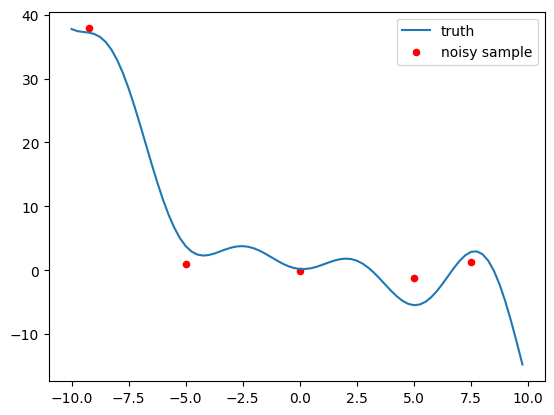

In [83]:
sample_var = 2.5

def f(x): return np.sin(x) * x - np.pow(x - 2, 3) / 40
def sample(x): return f(x) + np.random.normal(scale=sample_var, size=x.shape)

grid = np.arange(-10, 10, 0.25)
grid_len = len(grid)
y = f(grid)

train_idx = [3, 20, 40, 60, 70]
train_x = np.array([grid[i] for i in train_idx])
train_y = sample(train_x)

plt.plot(grid, y, label="truth")
plt.scatter(train_x, train_y, color="red", label="noisy sample", marker="o", s=20)
plt.legend()
plt.show()

In [4]:
def kernel(n, f):
  kernel = np.zeros(shape=(n,n))
  coord = lambda x: (x - n//2)
  for i in range(n):
    for j in range(n):
      kernel[i][j] = f(coord(i), coord(j))
  return kernel

def gen_rbf(n, sigma=0.8, l=0.8):
  return kernel(n, lambda i, j: pow(sigma, 2) * exp(-pow(i - j, 2) / (2 * pow(l, 2))))

def gen_periodic(n, sigma=0.8, l=0.8, p=0.5):
  f = lambda i, j: pow(sigma, 2) * exp(-2 * pow(sin(pi * abs(i - j) / p), 2) / pow(l, 2))
  return kernel(n, f)

def gen_linear(n, sigma=0.3, sigmab=0.8, c=0):
  f = lambda i, j: pow(sigmab, 2) + max(pow(sigma, 2) * (i - c) * (j - c), 0)
  return kernel(n, f)

def combine_kernels(*kernels): return np.power(prod(kernels), 1 / len(kernels))

def sample_kernel(kernel, mean=None):
  if not mean: mean = np.zeros(len(kernel))
  return np.random.multivariate_normal(mean=np.zeros_like(grid), cov=kernel)

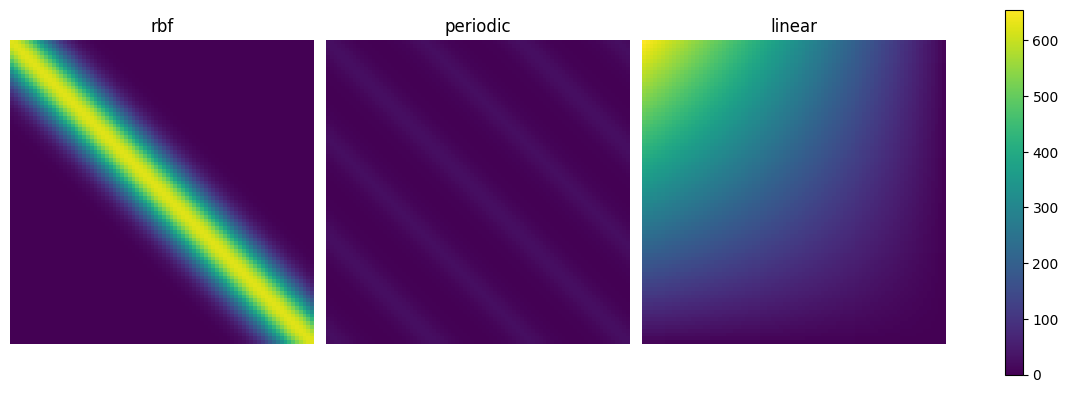

In [5]:
rbf = gen_rbf(grid_len, sigma=25, l=7)
periodic = gen_periodic(grid_len, sigma=5, l=0.9, p=.51)
linear = gen_linear(grid_len, sigma=0.32, sigmab=0.3, c=40)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
titles = ["rbf", "periodic", "linear"]

kernels = np.array([rbf, periodic, linear])
vmin, vmax = kernels.min(), kernels.max()

for ax, k, title in zip(axes, kernels, titles):
  im = ax.imshow(k, cmap="viridis", vmin=vmin, vmax=vmax)
  ax.set_title(title)
  ax.axis("off")
plt.tight_layout()
cbar = fig.colorbar(im, ax=axes, location='right')
plt.show()

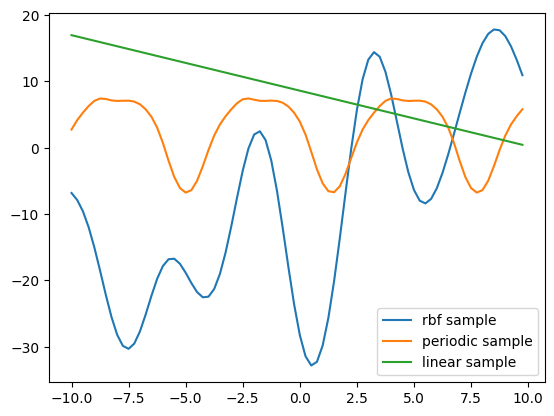

In [7]:
rbf_sample = sample_kernel(rbf)
periodic_sample = sample_kernel(periodic)
linear_sample = sample_kernel(linear)

plt.plot(grid, rbf_sample, label="rbf sample")
plt.plot(grid, periodic_sample, label="periodic sample")
plt.plot(grid, linear_sample, label="linear sample")
plt.legend()
plt.show()

/var/folders/zm/ygrnk4ys5y1_4lj8_m79srgm0000gn/T/ipykernel_71582/180392654.py:24: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  return np.random.multivariate_normal(mean=np.zeros_like(grid), cov=kernel)


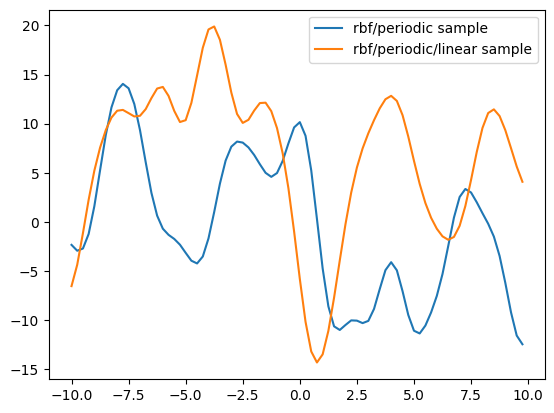

In [12]:
rp_sample = sample_kernel(combine_kernels(rbf, periodic))
all_kernel = combine_kernels(rbf, periodic, linear)
all_sample = sample_kernel(all_kernel)

plt.plot(grid, rp_sample, label="rbf/periodic sample")
plt.plot(grid, all_sample, label="rbf/periodic/linear sample")
plt.legend()
plt.show()

In [ ]:
def drag_vector(matrix, from_idx, to_idx, axis):
  vec = np.take(matrix, indices=from_idx, axis=axis)
  matrix = np.delete(matrix, from_idx, axis)
  return np.insert(matrix, to_idx, vec, axis)

# ad hoc unit tests!
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
expected = np.array([[7, 8, 9], [1, 2, 3], [4, 5, 6]])
assert(np.allclose(drag_vector(matrix, 2, 0, 0), expected))
expected = np.array([[3, 1, 2], [6, 4, 5], [9, 7, 8]])
assert(np.allclose(drag_vector(matrix, 2, 0, 1), expected))

def update_gp(mean, covariance, train_idx, train_y):
  '''returns posterior mean and covariance
  '''
  assert(len(train_idx) == len(train_y))
  assert(len(mean) == len(covariance))
  n_train = len(train_idx)
  '''break down into block covariance matrices first
  '''
  for to_idx, from_idx in enumerate(train_idx):
    mean = drag_vector(mean, from_idx, to_idx, axis=0)
    covariance = drag_vector(covariance, from_idx, to_idx, axis=0)
    covariance = drag_vector(covariance, from_idx, to_idx, axis=1)
  test_mean = mean[n_train:]
  train_cov = covariance[:n_train, :n_train] + (sample_var ** 2 * np.identity(n_train))
  test_cov = covariance[n_train:, n_train:]
  tt_cov = covariance[:n_train, n_train:]
  '''compute mean and covariance (this is the most mathy part)
  '''
  train_y = train_y + np.random.normal(scale=sample_var, size=train_y.shape)
  new_test_mean = test_mean + tt_cov.T @ inv(train_cov) @ train_y
  new_test_cov = test_cov - tt_cov.T @ inv(train_cov) @ tt_cov
  '''shuffle back from blocks into originally-sized matrixes
  '''
  mean = np.hstack([train_y, new_test_mean])
  top = np.hstack([np.zeros_like(train_cov), tt_cov])
  bot = np.hstack([tt_cov.T, new_test_cov])
  covariance = np.vstack([top, bot])
  for from_idx, to_idx in reversed(list(enumerate(train_idx))):
    mean = drag_vector(mean, from_idx, to_idx, axis=0)
    covariance = drag_vector(covariance, from_idx, to_idx, axis=0)
    covariance = drag_vector(covariance, from_idx, to_idx, axis=1)
  return mean, covariance + sample_var ** 2 * np.identity(grid_len)

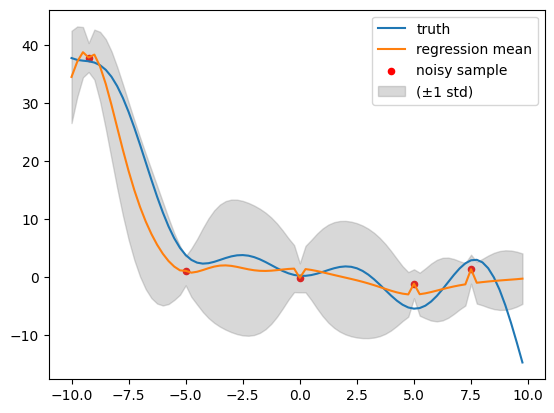

In [100]:
mean = np.zeros_like(grid)
meanp, variancep = update_gp(mean, all_kernel, train_idx, train_y)
stddevp = np.sqrt(variancep.diagonal())
upper = meanp + stddevp
lower = meanp - stddevp

plt.plot(grid, y, label="truth")
plt.plot(grid, meanp, label="regression mean")
plt.scatter(train_x, train_y, color="red", label="noisy sample", marker="o", s=20)
plt.fill_between(grid, lower, upper, color="gray", alpha=0.3, label="(±1 std)")
plt.legend()
plt.show()